# Implementando um classificador baseado em distância com um circuito de interferência quântica
##### [Maria Schuld, Mark Fingerhuth, Francesco Petruccione](https://arxiv.org/abs/1703.10793)

O classificador quântico aqui disposto utiliza a interferência quântica para medir a distância de um vetor de entrada para cada um dos vetores de treinamento e assim classificá-lo. Como prova de conceito, é montado um circuito quântico para classificar instâncias do conjuto de dados [Iris](http://archive.ics.uci.edu/ml/datasets/Iris).

## Circuito

![title](circuit.jpg)

## Implementação

In [18]:
# Install Libs
import sys
!{sys.executable} -m pip install --user numpy
!{sys.executable} -m pip install --user matplotlib
!{sys.executable} -m pip install --user qiskit
!{sys.executable} -m pip install --user scikit-learn

In [1]:
# Import Libs
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import *
import qutils
import iris
import math

In [2]:
# Auxiliary function definitions
def calculate_theta(sample):        
    if sample[0] < 0 and sample[1] < 0:
        value = sample[1]
        theta = math.acos(value)*2+math.pi
    elif sample[1] < 0:
        value = sample[1]
        theta = math.asin(value)*2
    else:
        value = sample[0]
        theta = math.acos(value)*2
    
    return theta

In [3]:
# Preprocessing
classes = [0,1]
features = [0,1]
input_vector_index = 28
training_vector_indexes = [33, 85]

X, y = iris.load_dataset(classes=classes, features=features)
X = iris.preprocess(X)

input_vector_theta = calculate_theta(X[input_vector_index])
training_vector_thetas = [
    calculate_theta(X[training_vector_indexes[0]]),
    calculate_theta(X[training_vector_indexes[1]])
]

In [4]:
# Create Circuit
q = QuantumRegister(4, 'q')
c = ClassicalRegister(2, 'c')
qc = QuantumCircuit(q, c)

In [5]:
# Subcircuit A
qc.h(q[[0,1]])

qc.barrier()
qutils.wavefunction(qc)

0.5  |0000>   0.5  |1000>   0.5  |0100>   0.5  |1100>   


In [6]:
# Subcircuit B
ry_input = input_vector_theta / 2.0
qc.cx(q[0], q[2])
qc.ry((-1 * ry_input), q[2])
qc.cx(q[0], q[2])
qc.x(q[0])
qc.ry(ry_input, q[2])

qc.barrier()
qutils.wavefunction(qc)

-0.27879  |0000>   0.5  |1000>   -0.27879  |0100>   0.5  |1100>   0.41506  |0010>   0.41506  |0110>   


In [7]:
# Subcircuit C
ry_input = training_vector_thetas[0] / 4.0
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry(ry_input, q[2])
qc.cx(q[1], q[2])
qc.ry((-1 * ry_input), q[2])
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry((-1 * ry_input), q[2])
qc.cx(q[1], q[2])
qc.ry(ry_input, q[2])

qc.x(q[1])

qc.barrier()
qutils.wavefunction(qc)

-0.27879  |0000>   0.00982  |1000>   -0.27879  |0100>   0.5  |1100>   0.41506  |0010>   0.4999  |1010>   0.41506  |0110>   


In [8]:
# Subcircuit D
ry_input = training_vector_thetas[1] / 4.0
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry(ry_input, q[2])
qc.cx(q[1], q[2])
qc.ry((-1 * ry_input), q[2])
qc.ccx(q[0], q[1], q[2])
qc.cx(q[1], q[2])
qc.ry((-1 * ry_input), q[2])
qc.cx(q[1], q[2])
qc.ry(ry_input, q[2])

qc.barrier()
qutils.wavefunction(qc)

-0.27879  |0000>   0.00982  |1000>   -0.27879  |0100>   0.39757  |1100>   0.41506  |0010>   0.4999  |1010>   0.41506  |0110>   0.30322  |1110>   


In [9]:
# Subcircuit E
qc.cx(q[1], q[3])

qc.barrier()
qutils.wavefunction(qc)

-0.27879  |0000>   0.00982  |1000>   0.41506  |0010>   0.4999  |1010>   -0.27879  |0101>   0.39757  |1101>   0.41506  |0111>   0.30322  |1111>   


In [10]:
# Subcircuit F
qc.h(q[0])

qutils.wavefunction(qc)

-0.19019  |0000>   -0.20408  |1000>   0.64698  |0010>   -0.05999  |1010>   0.08399  |0101>   -0.47826  |1101>   0.5079  |0111>   0.07908  |1111>   


In [11]:
# Measure
qc.measure(q[0],c[0])
qc.barrier()
qc.measure(q[3],c[1])

qutils.wavefunction(qc)

-0.28203  |0000>   0.9594  |0010>   


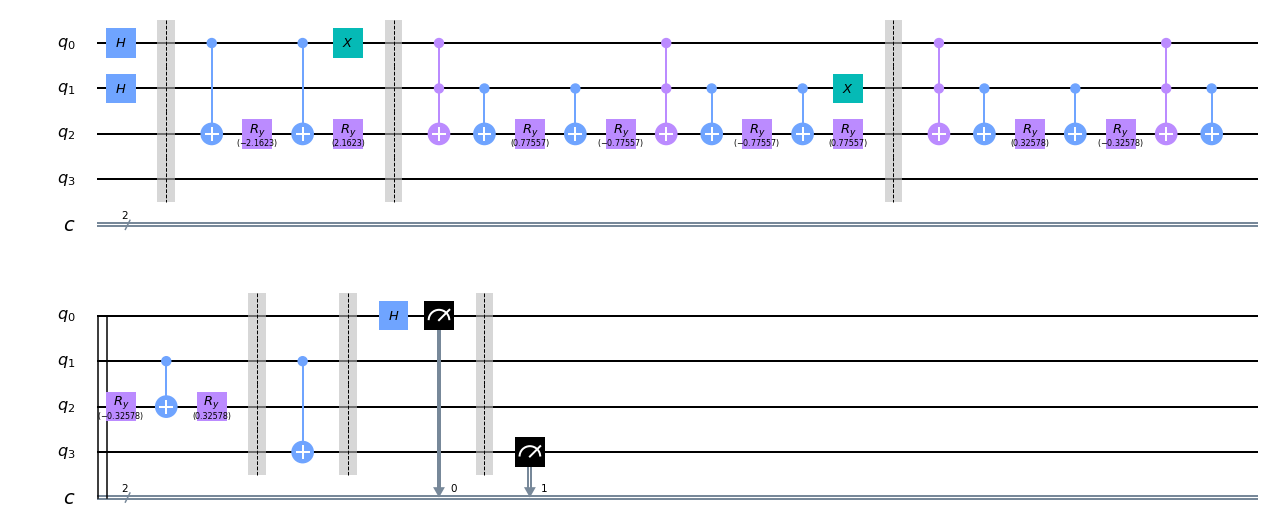

In [12]:
# Print circuit
qc.draw(output = 'mpl')

In [13]:
qutils.measurement(qc, shots = 1024)

63 |10>  443 |00>  265 |11>  253 |01>  


In [14]:
# Simulate
backend = BasicAer.get_backend('qasm_simulator')
counts = execute(qc, backend, shots=1024).result().get_counts(qc)

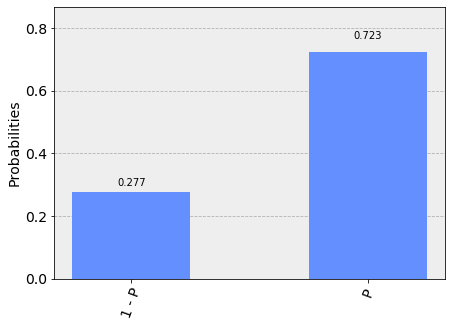

In [15]:
# Postselection probability
pacc = (counts['00'] + counts['10']) / sum(counts.values())
visualization.plot_histogram({ 'P': pacc, '1 - P': (1 - pacc) })

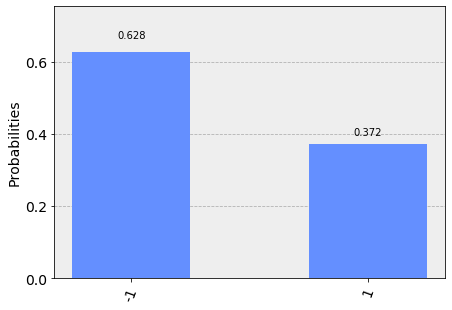

In [16]:
# Classification probability
visualization.plot_histogram({ '-1': counts['00'], '1': counts['10'] })